# Queue Functions

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading orders

In [3]:
def readorder(o):
    ot=o['OrderType']
    bs=o['Direction']
    am=o['Quantity']
    p=o['Price']
    dt=o['Date']
    tr=o['Trader']
    oid=o['OrderId']
    oc=o['OrderCaracteristics']
    return {'OrderType':ot,'Direction':bs,\
            'Quantity':am,'Price':p,\
            'Date':dt,'Trader':tr,\
            'OrderId':oid,'OrderCaracteristics':oc}

1. 'OrderType':ot ('L','M','C')
2. 'Direction':bs ('B','S')
3. 'Quantity':am
4. 'Price':p
5. 'Date':dt
6. 'Trader':tr
7. 'OrderId':oid
8. 'OrderCaracteristics':oc

## The logic

Two dicts: Buy Queue and Sell Queue (bq and sq), indexed by prices

Trading phases (indicated by status: tp):

a. Pre-matching ('PM'): only add and cancel in queues, each independent - no matching

b. Opening auction ('OA'): match both queues; to cheat, we take trades marked as OpeningAuction and cancel them from queue

c. Normal matching ('NM'): orders are checked against opposite queue first before adding

For now, book is aggregated (no individual orders), but readrorder has individual order information to improve this in a later stage

Event and order classifications:

Event Types (ot):

a. Inclusion

    a.1 Limit order ('L')
    
    a.2 Market order ('M')
    
b. Cancel ('C')

Event processing:

f(bq,sq,tp,order)=>(nbq,nsq,dtrd,success)

Where:

-order includes the ot information

-nbq and nsq are the new buy and sell queues

-dtrd is a dict of the trades triggered by order

-success is a flag that is True if the cancel was successful and False if not
    or True if a market order filled totally and False if not

## The basic queue functions

### Queue examples

In [2]:
bq1={97:30,99:20,98:40,100:10,96:5}
sq1={102:30,101:20,103:40,104:10,105:5}
dtrd1={100:20,101:30}

### Retrieval

In [5]:
def first(q):
    return list(sorted(q.items()))[0]

def firstn(q,n):
    return dict(list(sorted(q.items()))[:n])

def last(q):
    return list(sorted(q.items()))[-1]

def lastn(q,n):
    return dict(list(sorted(q.items()))[-n:])

def bestba(bq,sq):
    bfb=True
    bfa=True
    try:
        bestb=last(bq)[0]
    except:
        bestb=0
        bfb=False
    try:
        besta=first(sq)[0]
    except:
        besta=0
        bfa=False
    return [bestb,besta,bfb,bfa]

def totam(q):
    return sum(q.values())

In [6]:
[first(sq1),firstn(sq1,2)]

[(101, 20), {101: 20, 102: 30}]

In [7]:
[last(bq1),lastn(bq1,2)]

[(100, 10), {99: 20, 100: 10}]

In [8]:
bestba(bq1,sq1)

[100, 101, True, True]

In [9]:
bestba(bq1,{})

[100, 0, True, False]

In [10]:
bestba({},sq1)

[0, 101, False, True]

In [11]:
totam(bq1)

105

In [12]:
totam(sq1)

105

### Sort queues

In [13]:
def sortd(q):
    return dict(sorted(q.items()))

In [14]:
sortd(bq1)

{96: 5, 97: 30, 98: 40, 99: 20, 100: 10}

### Clean zeros

In [15]:
def nonzeroq(q):
    return dict(((k,v) for (k,v) in q.items() if v!=0))

In [16]:
nonzeroq({97:30,99:20,98:0,100:10,96:5})

{96: 5, 97: 30, 99: 20, 100: 10}

### Queues to DataFrames and vice-versa

In [3]:
def qtodf(q,qn,rev=False):
    # rev is a variable that should be False as a default 
    # (ascending sort order); in the Buy Queue it can be 
    # used as True for the cumulative queue
    if qn=='T':
        df=pd.DataFrame.from_dict(q,orient='index')
        df.index.name='Price'
        try:
            df.columns=['Quantity']
        except:
            pass
        return df
    else:
        if qn=='B':
            qcol='QtBid'
        else:
            qcol='QtAsk'
        df=pd.DataFrame(sorted(q.items()),\
                columns=['Price',qcol])\
                .set_index('Price')
        df.sort_index(ascending=not(rev),inplace=True)
        return df
    
def bsqtodf(bq,sq):
    dfbq=qtodf(bq,'B')
    dfsq=qtodf(sq,'S')
    dfq=pd.concat([dfbq,dfsq])
    return dfq
    
def bsqtodf1(bq,sq):
    dfbq=qtodf(bq,'B')
    dfsq=qtodf(sq,'S')
    dfq=pd.concat([dfbq,dfsq],axis=1)
    return dfq

def bsqntodf(bq,sq,n):
    dfbq=qtodf(lastn(bq,n),'B')
    dfsq=qtodf(firstn(sq,n),'S')
    dfq=pd.concat([dfbq,dfsq])
    return dfq

def bsqntodf1(bq,sq,n):
    dfbq=qtodf(lastn(bq,n),'B')
    dfsq=qtodf(firstn(sq,n),'S')
    dfq=pd.concat([dfbq,dfsq],axis=1)
    return dfq

# The functions bsqtodf1 and bsqntodf1 will be useful
# during the pre-matching, where the same price will
# have both Bid and Ask amounts

In [18]:
qtodf(bq1,'B',True)

,QtBid
Price,
100,10
99,20
98,40
97,30
96,5


In [19]:
qtodf(sq1,'S')

,QtAsk
Price,
101,20
102,30
103,40
104,10
105,5


In [20]:
bsqtodf(bq1,sq1)

,QtAsk,QtBid
Price,,
96,NaN,5.0
97,NaN,30.0
98,NaN,40.0
99,NaN,20.0
100,NaN,10.0
101,20.0,NaN
102,30.0,NaN
103,40.0,NaN
104,10.0,NaN


In [25]:
bsqtodf1(bq1,sq1)

,QtBid,QtAsk
Price,,
96,5.0,NaN
97,30.0,NaN
98,40.0,NaN
99,20.0,NaN
100,10.0,NaN
101,NaN,20.0
102,NaN,30.0
103,NaN,40.0
104,NaN,10.0


In [26]:
bsqntodf(bq1,sq1,2)

,QtAsk,QtBid
Price,,
99,NaN,20.0
100,NaN,10.0
101,20.0,NaN
102,30.0,NaN


In [27]:
bsqntodf1(bq1,sq1,2)

,QtBid,QtAsk
Price,,
99,20.0,NaN
100,10.0,NaN
101,NaN,20.0
102,NaN,30.0


In [22]:
qtodf({},'S')

,QtAsk
Price,


In [23]:
qtodf(dtrd1,'T')

,Quantity
Price,
100,20
101,30


In [24]:
qtodf({},'T')

""
Price


In [4]:
def qtodfni(q,qn,dcount,ts):
    dfq=qtodf(q,qn)
    dfq.reset_index(inplace=True)
    dfq['dcount']=dcount
    dfq['ts']=ts
    return dfq

def bsqtodfni(bq,sq,dcount,ts):
    dfq=bsqtodf(bq,sq)
    dfq.reset_index(inplace=True)
    dfq['dcount']=dcount
    dfq['ts']=ts
    return dfq

def bsqntodfni(bq,sq,n,dcount,ts):
    dfq=bsqntodf(bq,sq,n)
    dfq.reset_index(inplace=True)
    dfq['dcount']=dcount
    dfq['ts']=ts
    return dfq

In [30]:
qtodfni(bq1,'B',1,2)

,Price,QtBid,dcount,ts
0,96,5,1,2
1,97,30,1,2
2,98,40,1,2
3,99,20,1,2
4,100,10,1,2


In [31]:
qtodfni(sq1,'S',1,2)

,Price,QtAsk,dcount,ts
0,101,20,1,2
1,102,30,1,2
2,103,40,1,2
3,104,10,1,2
4,105,5,1,2


In [32]:
bsqtodfni(bq1,sq1,1,2)

,Price,QtAsk,QtBid,dcount,ts
0,96,NaN,5.0,1,2
1,97,NaN,30.0,1,2
2,98,NaN,40.0,1,2
3,99,NaN,20.0,1,2
4,100,NaN,10.0,1,2
5,101,20.0,NaN,1,2
6,102,30.0,NaN,1,2
7,103,40.0,NaN,1,2
8,104,10.0,NaN,1,2
9,105,5.0,NaN,1,2


In [33]:
bsqntodfni(bq1,sq1,2,10,20)

,Price,QtAsk,QtBid,dcount,ts
0,99,NaN,20.0,10,20
1,100,NaN,10.0,10,20
2,101,20.0,NaN,10,20
3,102,30.0,NaN,10,20


In [34]:
qtodfni(dtrd1,'T',1,2)

,Price,Quantity,dcount,ts
0,100,20,1,2
1,101,30,1,2


In [35]:
qtodfni({},'T',1,2)

,Price,dcount,ts


In [5]:
def dftoqs(df):
    bq=df['QtBid'].dropna().to_dict()
    sq=df['QtAsk'].dropna().to_dict()
    return [bq,sq]

def fulldftoqs(df):
    dfi=df.copy().set_index('Price')
    return dftoqs(dfi)

In [37]:
dftoqs(pd.concat([qtodf(bq1,'B'),qtodf(sq1,'S')]))

[{96: 5.0, 97: 30.0, 98: 40.0, 99: 20.0, 100: 10.0},
 {101: 20.0, 102: 30.0, 103: 40.0, 104: 10.0, 105: 5.0}]

In [38]:
pd.concat([qtodf(bq1,'B'),qtodf(sq1,'S')]).reset_index()

,Price,QtAsk,QtBid
0,96,NaN,5.0
1,97,NaN,30.0
2,98,NaN,40.0
3,99,NaN,20.0
4,100,NaN,10.0
5,101,20.0,NaN
6,102,30.0,NaN
7,103,40.0,NaN
8,104,10.0,NaN
9,105,5.0,NaN


In [39]:
fulldftoqs(pd.concat([qtodf(bq1,'B'),qtodf(sq1,'S')]).reset_index())

[{96: 5.0, 97: 30.0, 98: 40.0, 99: 20.0, 100: 10.0},
 {101: 20.0, 102: 30.0, 103: 40.0, 104: 10.0, 105: 5.0}]

### Cumulative queues, outputs and plots

In [6]:
def cumq(q,qn):
    if qn=='B':
        dfq=qtodf(q,qn,True)
        qcol='QtBid'
    elif qn=='S':
        dfq=qtodf(q,qn,False)
        qcol='QtAsk'
    else:
        dfq=qtodf(q,qn,False)
        qcol='Quantity'
    return dfq.cumsum().to_dict()[qcol]

def dfcumbsq(bq,sq):
    return bsqtodf(cumq(bq,'B'),cumq(sq,'S'))

def dfcumbsq1(bq,sq):
    return bsqtodf1(cumq(bq,'B'),cumq(sq,'S'))

def dfcumbsqn(bq,sq,n):
    return bsqntodf(cumq(bq,'B'),cumq(sq,'S'),n)

In [41]:
cumq(bq1,'B')

{96: 105, 97: 100, 98: 70, 99: 30, 100: 10}

In [42]:
cumq(sq1,'S')

{101: 20, 102: 50, 103: 90, 104: 100, 105: 105}

In [43]:
cumq(dtrd1,'T')

{100: 20, 101: 50}

In [44]:
dfcumbsq(bq1,sq1)

,QtAsk,QtBid
Price,,
96,NaN,105.0
97,NaN,100.0
98,NaN,70.0
99,NaN,30.0
100,NaN,10.0
101,20.0,NaN
102,50.0,NaN
103,90.0,NaN
104,100.0,NaN


In [45]:
dfcumbsq1(bq1,sq1)

,QtBid,QtAsk
Price,,
96,105.0,NaN
97,100.0,NaN
98,70.0,NaN
99,30.0,NaN
100,10.0,NaN
101,NaN,20.0
102,NaN,50.0
103,NaN,90.0
104,NaN,100.0


In [46]:
dfcumbsqn(bq1,sq1,3)

,QtAsk,QtBid
Price,,
98,NaN,70.0
99,NaN,30.0
100,NaN,10.0
101,20.0,NaN
102,50.0,NaN
103,90.0,NaN


In [7]:
def plotq(bq,sq):
    bsqtodf1(bq,sq).plot(kind='bar',color=['red','blue'],\
         title='Bid/Ask Queue');
    plt.axhline(0,color='black');

def plotqn(bq,sq,n):
    bsqntodf1(bq,sq,n).plot(kind='bar',color=['red','blue'],\
         title='Bid/Ask Queue');
    plt.axhline(0,color='black');

def plotdf(df):
    df.plot(kind='bar',color=['red','blue'],\
         title='Bid/Ask Queue');
    plt.axhline(0,color='black');

def plotcumq(bq,sq):
    dfcumbsq1(bq,sq).plot(kind='bar',color=['red','blue'],\
            title='Cumulative Bid/Ask Queue');
    plt.axhline(0,color='black');
    
def plotcumqn(bq,sq,n):
    dfcumbsqn(bq,sq,n).plot(kind='bar',color=['red','blue'],\
            title='Cumulative Bid/Ask Queue');
    plt.axhline(0,color='black');

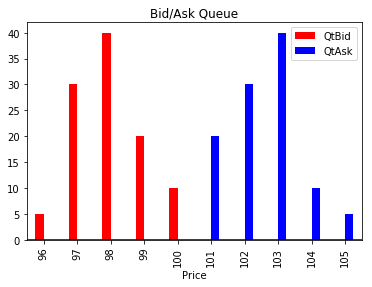

In [8]:
plotq(bq1,sq1)

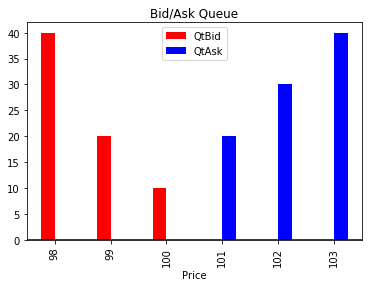

In [49]:
plotqn(bq1,sq1,3)

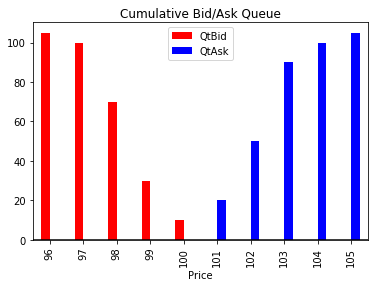

In [50]:
plotcumq(bq1,sq1)

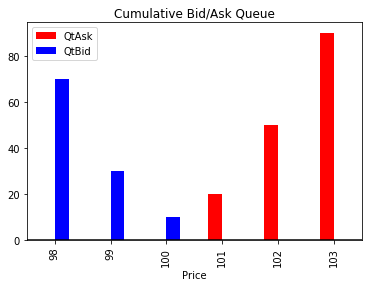

In [51]:
plotcumqn(bq1,sq1,3)

## Orders and events

1. 'OrderType':ot ('L','M','C')
2. 'Direction':bs ('B','S')
3. 'Quantity':am
4. 'Price':p
5. 'Date':dt
6. 'Trader':tr
7. 'OrderId':oid
8. 'OrderCaracteristics':oc

Trading phases (indicated by status: tp):

a. Pre-matching ('PM'): only add and cancel in queues, each independent - no matching

b. Opening auction ('OA'): match both queues; to cheat, we take trades marked as OpeningAuction and cancel them from queue

c. Normal matching ('NM'): orders are checked against opposite queue first before adding

#### Test orders

In [52]:
orderLBa={'Date': '2018-03-01','Direction': 'B','OrderType': 'L',\
 'Price': 98,'Quantity': 100,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [53]:
orderLBm={'Date': '2018-03-01','Direction': 'B','OrderType': 'L',\
 'Price': 102,'Quantity': 100,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [54]:
orderLBmt={'Date': '2018-03-01','Direction': 'B','OrderType': 'L',\
 'Price': 102,'Quantity': 40,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [55]:
orderLSa={'Date': '2018-03-01','Direction': 'S','OrderType': 'L',\
 'Price': 102,'Quantity': 100,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [56]:
orderLSm={'Date': '2018-03-01','Direction': 'S','OrderType': 'L',\
 'Price': 98,'Quantity': 100,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [57]:
orderLSmt={'Date': '2018-03-01','Direction': 'S','OrderType': 'L',\
 'Price': 98,'Quantity': 40,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [58]:
orderMB={'Date': '2018-03-01','Direction': 'B','OrderType': 'M',\
 'Price': 0,'Quantity': 65,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [59]:
orderMS={'Date': '2018-03-01','Direction': 'S','OrderType': 'M',\
 'Price': 0,'Quantity': 65,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [60]:
orderMBt={'Date': '2018-03-01','Direction': 'B','OrderType': 'M',\
 'Price': 0,'Quantity': 120,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [61]:
orderMSt={'Date': '2018-03-01','Direction': 'S','OrderType': 'M',\
 'Price': 0,'Quantity': 120,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [62]:
orderCBT={'Date': '2018-03-01','Direction': 'B','OrderType': 'C',\
 'Price': 98,'Quantity': 35,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [63]:
orderCBF1={'Date': '2018-03-01','Direction': 'B','OrderType': 'C',\
 'Price': 99,'Quantity': 35,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [64]:
orderCBF2={'Date': '2018-03-01','Direction': 'B','OrderType': 'C',\
 'Price': 90,'Quantity': 35,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [65]:
orderCST={'Date': '2018-03-01','Direction': 'S','OrderType': 'C',\
 'Price': 103,'Quantity': 35,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [66]:
orderCSF1={'Date': '2018-03-01','Direction': 'S','OrderType': 'C',\
 'Price': 102,'Quantity': 35,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [67]:
orderCSF2={'Date': '2018-03-01','Direction': 'S','OrderType': 'C',\
 'Price': 110,'Quantity': 35,'Trader':1,'OrderId':1,\
 'OrderCaracteristics':1}

In [68]:
orderlist=['orderLBa','orderLBm','orderLBmt',\
           'orderMB','orderMBt',\
           'orderCBT','orderCBF1','orderCBF2',\
           'orderLSa','orderLSm','orderLSmt',\
           'orderMS','orderMSt',\
           'orderCST','orderCSF1','orderCSF2']

### Auctions

In [116]:
def aucpx(bq,sq,cumf=True):
    if cumf:
        bsqc=pd.concat([qtodf(bq,'B'),\
                        qtodf(sq,'S')],\
        axis=1,join='inner')
    else:
        bsqc=pd.concat([qtodf(cumq(bq,'B'),'B'),\
                     qtodf(cumq(sq,'S'),'S')],\
        axis=1,join='inner')
    bsqc['Match']=bsqc.min(axis=1)
    return {bsqc['Match'].idxmax():bsqc['Match'].max()}

def aucpxLM(bqL,sqL,bqM,sqM):
    bqcL=qtodf(cumq(bqL,'B'),'B')
    sqcL=qtodf(cumq(sqL,'S'),'S')
    bsqcL=pd.concat([bqcL,sqcL],axis=1)
    bsqcL['QtAsk'].fillna(method='ffill',inplace=True)
    bsqcL['QtBid'].fillna(method='bfill',inplace=True)
    if sqM!={}:
        bsqcL['QtAsk']+=sqM[0]
    if bqM!={}:
        bsqcL['QtBid']+=bqM[0]
    bsqcL['Match']=bsqcL.min(axis=1)
    bsqcLv=bsqcL.dropna()
    return {bsqcLv['Match'].idxmax():bsqcLv['Match'].max()}

def cleanauct(bqL,sqL,bqM,sqM,amtrdpx,amtrdoa):
    if bqM!={}:
        bqm0=bqM[0]
    else:
        bqm0=0
    if sqM!={}:
        sqm0=sqM[0]
    else:
        sqm0=0
    amoabid=qtodf(bqL,'B').loc[amtrdpx:].sum().values[0]+bqm0
    amoaask=qtodf(sqL,'S').loc[:amtrdpx].sum().values[0]+sqm0
    amoabidrem=amoabid-amtrdoa
    amoaaskrem=amoaask-amtrdoa
    bqLr,trdBoa=selqpx(bqL,'B',amtrdpx)
    sqLr,trdSoa=selqpx(sqL,'S',amtrdpx)
    if amoabidrem>0:
        bqLr[amtrdpx]=amoabidrem
    elif amoaaskrem>0:
        sqLr[amtrdpx]=amoaaskrem
    return (bqLr,sqLr)

In [92]:
bqa={97:30,99:20,98:40,100:10,96:5}
sqa={98:30,97:20,99:40,100:10,101:5}

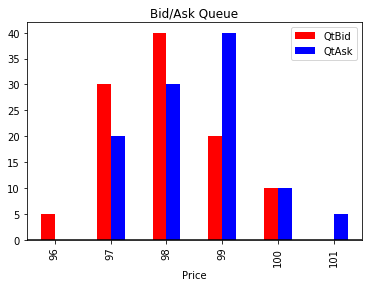

In [93]:
plotq(bqa,sqa)

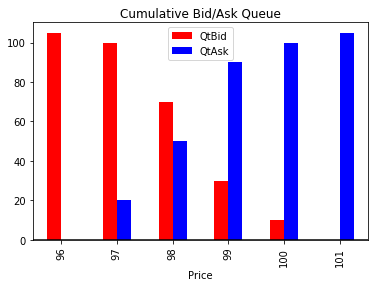

In [94]:
plotcumq(bqa,sqa)

Find clearing price and amount traded

In [98]:
aucpxLM(bqa,sqa,{},{})

{98: 50.0}

Remaining queues (there should be no crossing)

In [117]:
cleanauct(bqa,sqa,{},{},98,50)

({96: 5, 97: 30, 98: 20}, {99: 40, 100: 10, 101: 5})

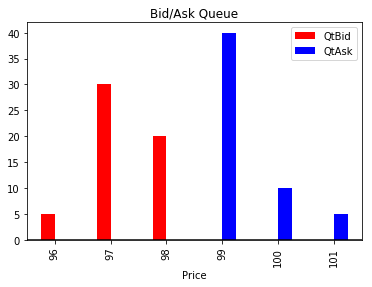

In [119]:
plotq({96: 5, 97: 30, 98: 20}, {99: 40, 100: 10, 101: 5})

#### Matching Functions

In [72]:
def sumo(o):
    return [o['OrderType'],o['Direction'],{o['Price']:o['Quantity']}]

In [73]:
def addtodict(q,x):
    nq=q.copy()
    try:
        nq[x['Price']]+=x['Quantity']
    except:
        nq[x['Price']]=x['Quantity']
    return [nq,True]

In [74]:
def subtractfromdict(q,x):
    nq=q.copy()
    cncl=True
    try:
        nq[x['Price']]-=x['Quantity']
    except:
        cncl=False
    try:
        if nq[x['Price']]<0:
            cncl=False
            nq=q.copy()
    except:
        pass
    return [nq,cncl]

In [75]:
def addcancel(q,x):
    if x['OrderType']=='C':
        return subtractfromdict(q,x)
    else:
        return addtodict(q,x)

In [76]:
def bsaddcancel(bq,sq,x):
    nbq=bq.copy()
    nsq=sq.copy()
    if x['Direction']=='B':
        nbq, cncl = addcancel(nbq,x)
    else:
        nsq, cncl = addcancel(nsq,x)
    if cncl:
        pro={}
    else:
        pro=x.copy()
    return [nbq,nsq,{},pro,cncl]

In [77]:
def selqam(q,qn,am):
    qc=cumq(q,qn)
    qsel=dict([(p,q[p]) for (p,v) in qc.items() if v>=am])
    dtrd=dict([(p,q[p]) for (p,v) in qc.items() if v<am])
    qre=am-totam(dtrd)
    if qre>0:
        if qn=='B':
            bb,ba,bfb,bfa=bestba(qsel,{})
            bff=bfb
            bp=bb
        else:
            bb,ba,bfb,bfa=bestba({},qsel)
            bff=bfa
            bp=ba
        if (bff and (qsel[bp]>=qre)):
            dtrd[bp]=qre
            qsel[bp]-=qre
    return [qsel,dtrd]

In [78]:
def selqpx(q,qn,px):
    if qn=='B':
        s=+1
    else:
        s=-1
    qsel=dict([(p,q[p]) for (p,v) in q.items() if s*p<s*px])
    dtrd=dict([(p,q[p]) for (p,v) in q.items() if s*p>=s*px])
    return [qsel,dtrd]

In [79]:
def bsmatch(bq,sq,x):
    # Initialize answers
    nbq=bq.copy()
    nsq=sq.copy()
    dtrd={}
    pro=x.copy()
    # Get order information
    otm=x['OrderType']=='M'
    am=x['Quantity']
    p=x['Price']
    bf=x['Direction']=='B'
    # If OrderType is M, do not filter by price
    if otm:
        if bf:
            p=1000000000
        else:
            p=0
    # Filter relevant queue by price
    # rq1 is the remaining queue (not tradable)
    # uq is the tradable queue
    if bf:
        rq1,uq=selqpx(sq,'S',p)
    else:
        rq1,uq=selqpx(bq,'B',p)
    # Total available on filtered queue
    uqt=totam(uq)
    if am>=uqt:
        # Shortcut if order amount greater than total available
        dtrd=uq.copy()
        if am==uqt:
            pro={}
        else:
            pro['Quantity']=am-uqt
        rq2={}
        if bf:
            nsq={**rq1, **rq2}
        else:
            nbq={**rq1, **rq2}
    else:
        # Break filtered queue into remaining and traded
        if bf:
            rq2, dtrd= selqam(nsq,'S',am)
            nsq={**rq1, **rq2}
        else:
            rq2, dtrd= selqam(nbq,'B',am)
            nbq={**rq1, **rq2}
        pro={}
    if ((pro!={}) and not(otm)):
        nbq,nsq,aux1,pro,aux2=bsaddcancel(nbq,nsq,pro)
    return [nbq,nsq,dtrd,pro,pro=={}]

In [80]:
def proq(bq,sq,do,status):
    nbq=bq.copy()
    nsq=sq.copy()
    if status=='PM':
        nbq, nsq, dtrd, pro, cncl = bsaddcancel(nbq,nsq,do)
    elif status=='OA':
        pass
    else:
        if do['OrderType']=='M':
            nbq, nsq, dtrd, pro, cncl = bsmatch(nbq,nsq,do)
        else:
            if do['OrderType']=='L':
                bb,ba,bfb,bfa=bestba(bq,sq)
                lbf=(do['Direction']=='B') and \
                    (do['Price']>=ba) and bfa
                lsf=(do['Direction']=='S') and \
                    (do['Price']<=bb) and bfb
                if (lbf or lsf):
                    nbq, nsq, dtrd, pro, cncl = bsmatch(nbq,nsq,do)
                else:
                    nbq, nsq, dtrd, pro, cncl = bsaddcancel(nbq,nsq,do)
            else:
                nbq, nsq, dtrd, pro, cncl = bsaddcancel(nbq,nsq,do)
    # Returns:
    # nbq: New buy queue
    # nsq: New sell queue
    # dtrd: Dict of trades (price:quantity)
    # pro: Remaining non-placed-in-queue market order
    # cncl: True if no problems in processing order
    # cncl: False if a cancel was not possible or 
    #     there is a market order failed to execute
    #     totally against the opposite queue
    return [nonzeroq(nbq),nonzeroq(nsq),dtrd,pro,cncl]

## Testing the orders

In [81]:
orderlist

['orderLBa',
 'orderLBm',
 'orderLBmt',
 'orderMB',
 'orderMBt',
 'orderCBT',
 'orderCBF1',
 'orderCBF2',
 'orderLSa',
 'orderLSm',
 'orderLSmt',
 'orderMS',
 'orderMSt',
 'orderCST',
 'orderCSF1',
 'orderCSF2']

### Adding to queue (no crossing)

#### Pre-matching

In [82]:
[bq1,sq1,sumo(orderLBa),proq(bq1,sq1,orderLBa,'PM'),
 bq1,sq1,sumo(orderLSa),proq(bq1,sq1,orderLSa,'PM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'B', {98: 100}],
 [{96: 5, 97: 30, 98: 140, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {},
  {},
  True],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'S', {102: 100}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 20, 102: 130, 103: 40, 104: 10, 105: 5},
  {},
  {},
  True]]

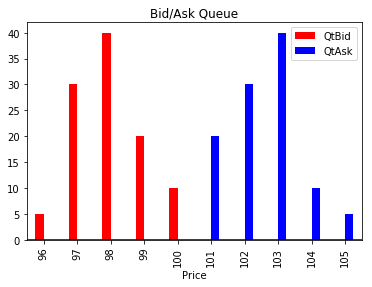

In [121]:
plotq(bq1,sq1)

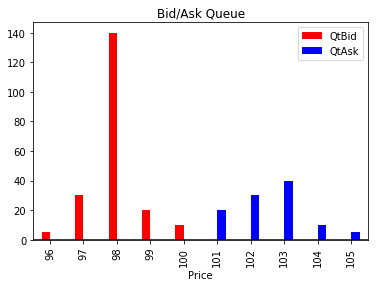

In [122]:
plotq({96: 5, 97: 30, 98: 140, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5})

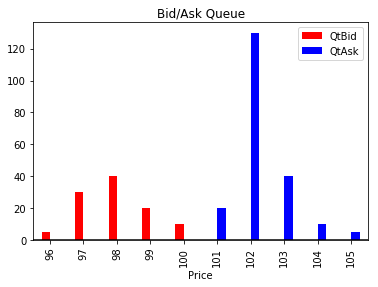

In [123]:
plotq({96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 20, 102: 130, 103: 40, 104: 10, 105: 5})

#### Normal matching

In [83]:
[bq1,sq1,sumo(orderLBa),proq(bq1,sq1,orderLBa,'NM'),
 bq1,sq1,sumo(orderLSa),proq(bq1,sq1,orderLSa,'NM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'B', {98: 100}],
 [{96: 5, 97: 30, 98: 140, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {},
  {},
  True],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'S', {102: 100}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 20, 102: 130, 103: 40, 104: 10, 105: 5},
  {},
  {},
  True]]

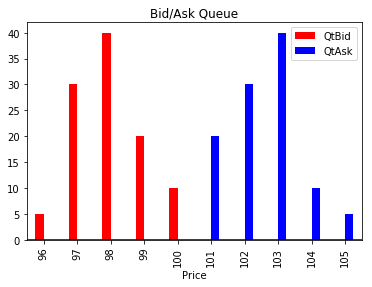

In [121]:
plotq(bq1,sq1)

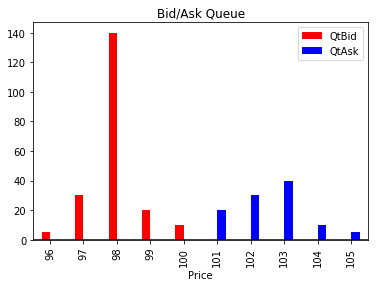

In [122]:
plotq({96: 5, 97: 30, 98: 140, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5})

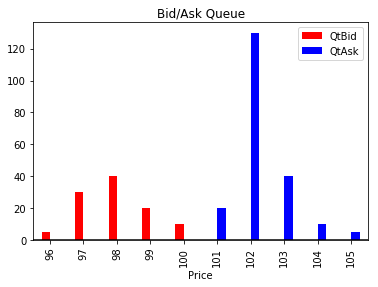

In [123]:
plotq({96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 20, 102: 130, 103: 40, 104: 10, 105: 5})

### Adding to queue (crossing)

#### Pre-matching

In [84]:
[bq1,sq1,sumo(orderLBm),proq(bq1,sq1,orderLBm,'PM'),
 bq1,sq1,sumo(orderLSm),proq(bq1,sq1,orderLSm,'PM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'B', {102: 100}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10, 102: 100},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {},
  {},
  True],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'S', {98: 100}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {98: 100, 101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {},
  {},
  True]]

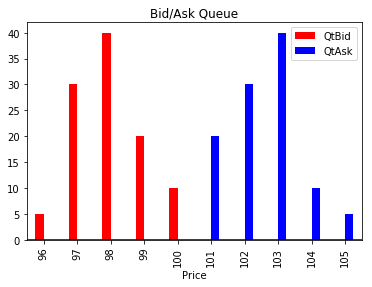

In [121]:
plotq(bq1,sq1)

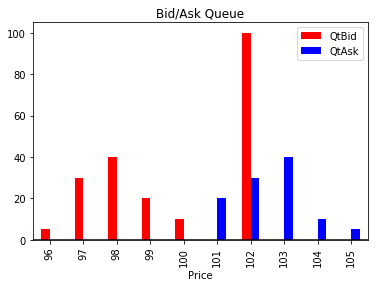

In [124]:
plotq({96: 5, 97: 30, 98: 40, 99: 20, 100: 10, 102: 100},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5})

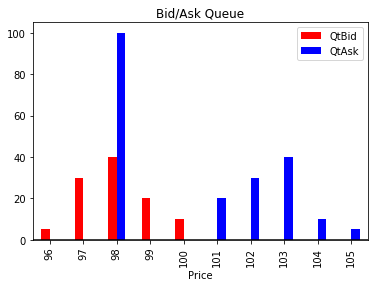

In [125]:
plotq({96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {98: 100, 101: 20, 102: 30, 103: 40, 104: 10, 105: 5})

### Executing against queue (crossing)

#### Normal matching - Limit, balance unfilled at price

In [85]:
[bq1,sq1,sumo(orderLBm),proq(bq1,sq1,orderLBm,'NM'),
 bq1,sq1,sumo(orderLSm),proq(bq1,sq1,orderLSm,'NM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'B', {102: 100}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10, 102: 50},
  {103: 40, 104: 10, 105: 5},
  {101: 20, 102: 30},
  {},
  True],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'S', {98: 100}],
 [{96: 5, 97: 30},
  {98: 30, 101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {98: 40, 99: 20, 100: 10},
  {},
  True]]

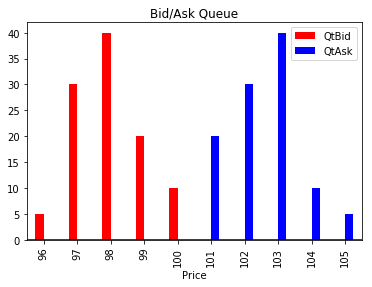

In [126]:
plotq(bq1,sq1)

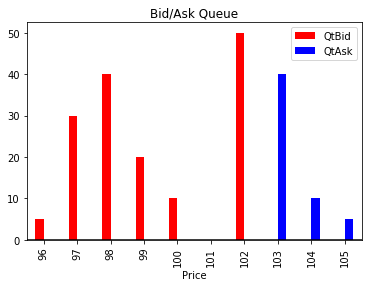

In [128]:
plotq({96: 5, 97: 30, 98: 40, 99: 20, 100: 10, 101: 0, 102: 50},
  {103: 40, 104: 10, 105: 5})

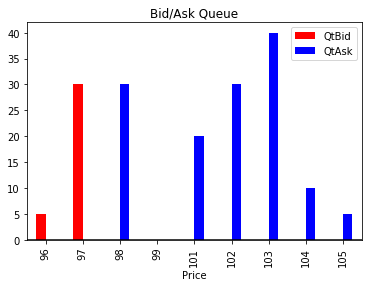

In [129]:
plotq({96: 5, 97: 30},
  {98: 30,99: 0, 101: 20, 102: 30, 103: 40, 104: 10, 105: 5})

#### Normal matching - Limit, balance filled at price

In [86]:
[bq1,sq1,sumo(orderLBmt),proq(bq1,sq1,orderLBmt,'NM'),
 bq1,sq1,sumo(orderLSmt),proq(bq1,sq1,orderLSmt,'NM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'B', {102: 40}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {102: 10, 103: 40, 104: 10, 105: 5},
  {101: 20, 102: 20},
  {},
  True],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['L', 'S', {98: 40}],
 [{96: 5, 97: 30, 98: 30},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {98: 10, 99: 20, 100: 10},
  {},
  True]]

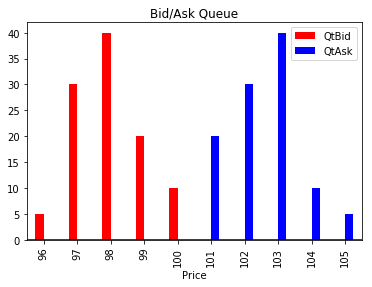

In [126]:
plotq(bq1,sq1)

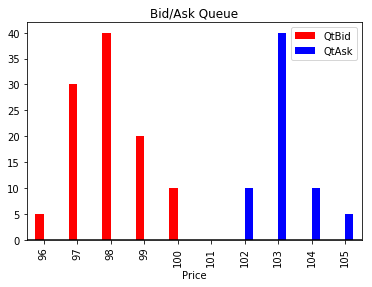

In [130]:
plotq({96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 0, 102: 10, 103: 40, 104: 10, 105: 5})

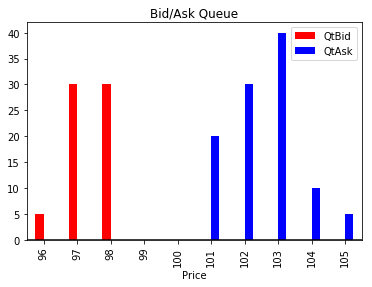

In [131]:
plotq({96: 5, 97: 30, 98: 30, 99: 0, 100: 0},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5})

#### Normal matching - Market, amount filled

In [87]:
[bq1,sq1,sumo(orderMB),proq(bq1,sq1,orderMB,'NM'),
 bq1,sq1,sumo(orderMS),proq(bq1,sq1,orderMS,'NM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['M', 'B', {0: 65}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {103: 25, 104: 10, 105: 5},
  {101: 20, 102: 30, 103: 15},
  {},
  True],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['M', 'S', {0: 65}],
 [{96: 5, 97: 30, 98: 5},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {98: 35, 99: 20, 100: 10},
  {},
  True]]

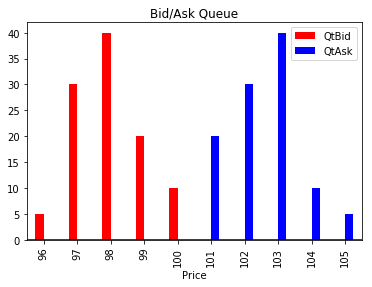

In [126]:
plotq(bq1,sq1)

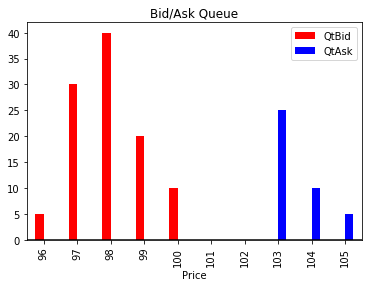

In [132]:
plotq({96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 0, 102: 0, 103: 25, 104: 10, 105: 5})

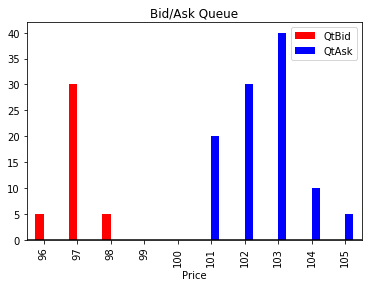

In [133]:
plotq({96: 5, 97: 30, 98: 5, 99: 0, 100: 0},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5})

#### Normal matching - Market, amount unfilled 
####   Returns hanging trade and False

In [88]:
[bq1,sq1,sumo(orderMBt),proq(bq1,sq1,orderMBt,'NM'),
 bq1,sq1,sumo(orderMSt),proq(bq1,sq1,orderMSt,'NM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['M', 'B', {0: 120}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {'Date': '2018-03-01',
   'Direction': 'B',
   'OrderCaracteristics': 1,
   'OrderId': 1,
   'OrderType': 'M',
   'Price': 0,
   'Quantity': 15,
   'Trader': 1},
  False],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['M', 'S', {0: 120}],
 [{},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {'Date': '2018-03-01',
   'Direction': 'S',
   'OrderCaracteristics': 1,
   'OrderId': 1,
   'OrderType': 'M',
   'Price': 0,
   'Quantity': 15,
   'Trader': 1},
  False]]

#### Normal matching - Cancel, amount cancelled

In [89]:
[bq1,sq1,sumo(orderCBT),proq(bq1,sq1,orderCBT,'NM'),
 bq1,sq1,sumo(orderCST),proq(bq1,sq1,orderCST,'NM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['C', 'B', {98: 35}],
 [{96: 5, 97: 30, 98: 5, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {},
  {},
  True],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['C', 'S', {103: 35}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 5, 104: 10, 105: 5},
  {},
  {},
  True]]

#### Normal matching - Cancel, amount greater than available 
####   Returns the cancel order and False

In [90]:
[bq1,sq1,sumo(orderCBF1),proq(bq1,sq1,orderCBF1,'NM'),
 bq1,sq1,sumo(orderCSF1),proq(bq1,sq1,orderCSF1,'NM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['C', 'B', {99: 35}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {},
  {'Date': '2018-03-01',
   'Direction': 'B',
   'OrderCaracteristics': 1,
   'OrderId': 1,
   'OrderType': 'C',
   'Price': 99,
   'Quantity': 35,
   'Trader': 1},
  False],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['C', 'S', {102: 35}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {},
  {'Date': '2018-03-01',
   'Direction': 'S',
   'OrderCaracteristics': 1,
   'OrderId': 1,
   'OrderType': 'C',
   'Price': 102,
   'Quantity': 35,
   'Trader': 1},
  False]]

#### Normal matching - Cancel, no amount at price 
####   Returns the cancel order and False

In [91]:
[bq1,sq1,sumo(orderCBF2),proq(bq1,sq1,orderCBF2,'NM'),
 bq1,sq1,sumo(orderCSF2),proq(bq1,sq1,orderCSF2,'NM')]

[{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['C', 'B', {90: 35}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {},
  {'Date': '2018-03-01',
   'Direction': 'B',
   'OrderCaracteristics': 1,
   'OrderId': 1,
   'OrderType': 'C',
   'Price': 90,
   'Quantity': 35,
   'Trader': 1},
  False],
 {96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
 {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
 ['C', 'S', {110: 35}],
 [{96: 5, 97: 30, 98: 40, 99: 20, 100: 10},
  {101: 20, 102: 30, 103: 40, 104: 10, 105: 5},
  {},
  {'Date': '2018-03-01',
   'Direction': 'S',
   'OrderCaracteristics': 1,
   'OrderId': 1,
   'OrderType': 'C',
   'Price': 110,
   'Quantity': 35,
   'Trader': 1},
  False]]